In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [18]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        probs = epsilon*np.ones(nA, dtype=float)/nA
        action = np.argmax(Q[observation])
        probs[action] += 1-epsilon 
        return probs
        # Implement this!
    return policy_fn

In [19]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i in range(num_episodes):
        state = env.reset()
        episode = []
        for j in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_s, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_s
        G = 0
        for j in range(len(episode)-1, -1, -1):
            s, a, r = episode[j]
            G = discount_factor*G + r
            returns_sum[s][a] += G
            returns_count[s][a] += 1
            Q[s][a] = returns_sum[s][a]/returns_count[s][a]
    
    return Q, policy

In [20]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=3, epsilon=0.1)
print('Q, policy:', Q, policy)

Q, policy: defaultdict(<function mc_control_epsilon_greedy.<locals>.<lambda> at 0x10ceb3d08>, {(17, 10, False): array([0., 0.]), (19, 7, False): array([-1.,  0.]), (13, 2, False): array([1., 0.])}) <function make_epsilon_greedy_policy.<locals>.policy_fn at 0x1100031e0>


In [21]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)

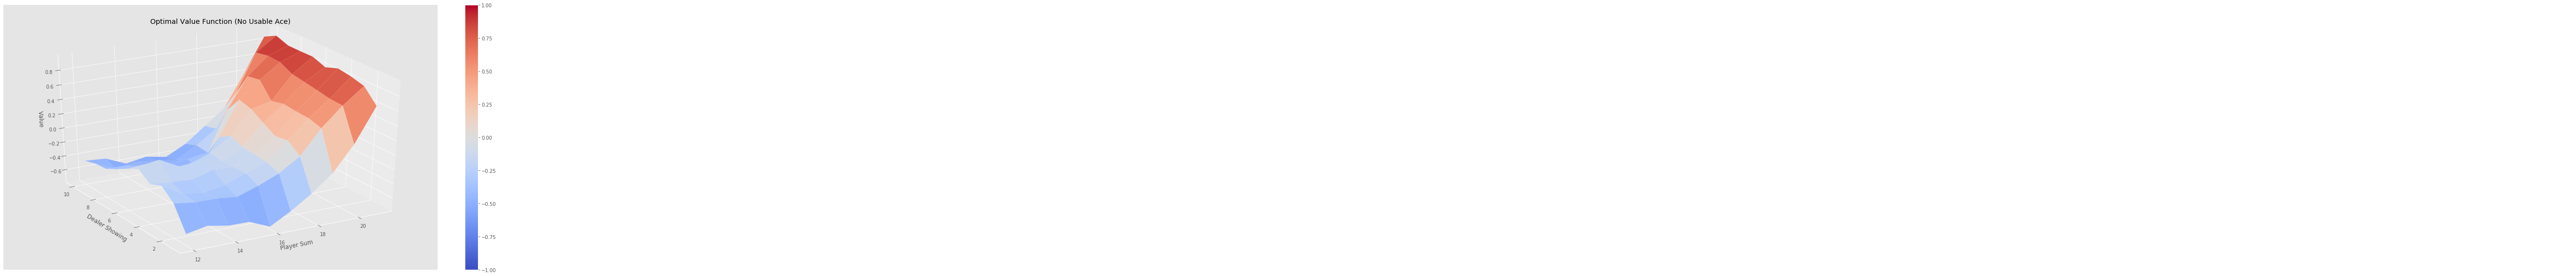

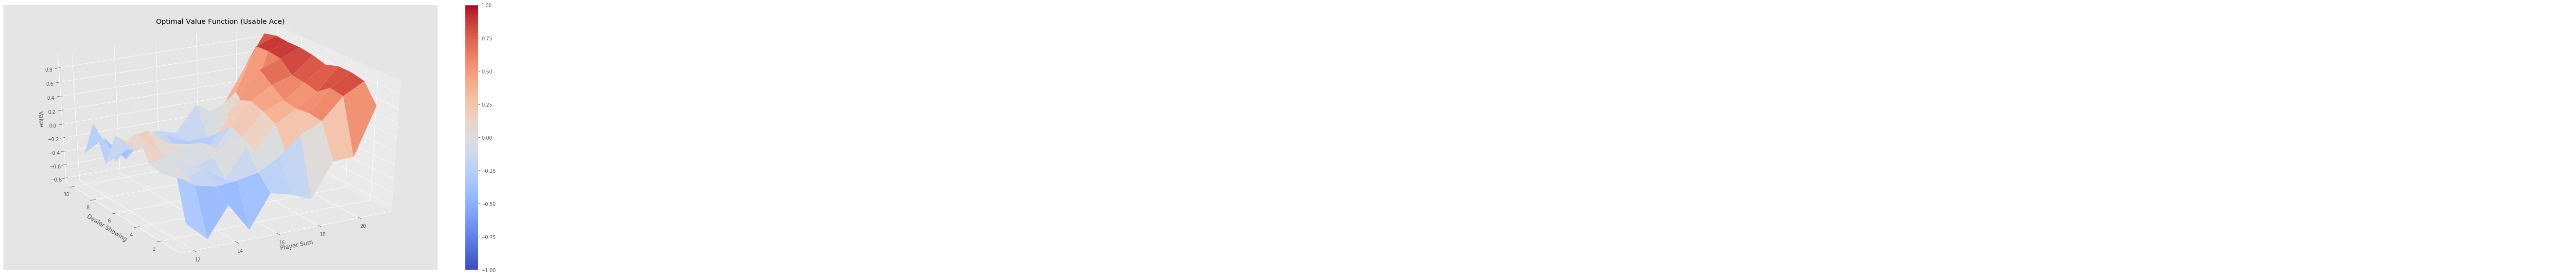

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")